In [1]:
%matplotlib inline


# 2 - Non-linear models: extended Kalman filter


As well as introducing various aspects of the Stone Soup framework, the previous tutorial
detailed the use of a Kalman filter. A significant problem in using the Kalman filter is that it
requires transition and sensor models to be linear-Gaussian. In practice, many models are not
like this and so alternatives are required. We examine the most commonly-used of such
alternatives, the extended Kalman filter [#]_ (EKF), in this tutorial.

## Background

Recall that the Kalman filter makes the following linear assumptions of the predicted state and
predicted measurement:

\begin{align}\mathbf{x}_{k|k-1} &= F_{k} \mathbf{x}_{k-1} + B_{k}\mathbf{u}_{k}\\
      \mathbf{z}_{k|k-1} &= H_{k} \mathbf{x}_{k|k-1}\end{align}

The EKF gets round the fact that $f(\cdot)$ and $h(\cdot)$ are not of this form by
making linear approximations about $\mathbf{x}_{k−1} = \boldsymbol{\mu}_{k−1}$ or
$\mathbf{x}_{k|k−1} = \boldsymbol{\mu}_{k|k−1}$. It does this by way of a Taylor expansion,

\begin{align}g(\mathbf{x})\rvert_{\mathbf{x}=\boldsymbol{\mu}} \approx \sum\limits_{|\alpha| \ge 0}
      \frac{(\mathbf{x} - \boldsymbol{\mu})^{\alpha}}{\alpha !}
      (\mathcal{D}^{\alpha} g)(\boldsymbol{\mu})\end{align}

This is usually truncated after the first term, meaning that either
$\tilde{F}(\mathbf{x}_{k-1}) \approx J(f)\rvert_{\mathbf{x}=\boldsymbol{\mu}_{k-1}}$ or
$\tilde{H}(\mathbf{x}_{k|k-1}) \approx J(h)\rvert_{\mathbf{x}=\boldsymbol{\mu}_{k|k-1}}$
or both, where $J(\cdot)$ is the Jacobian matrix. The calculation of the covariances,
including the innovation covariance, then proceeds in exactly the same way as in the Kalman
filter using these approximations,

\begin{align}\mathbf{x}_{k|k-1} &= f_{k}(\mathbf{x}_{k-1}) \\
      P_{k|k-1} &= \tilde{F}_{k}P_{k-1}\tilde{F}_{k}^T + Q_{k}\\
      \mathbf{x}_{k} &= \mathbf{x}_{k|k-1} +
                        \tilde{K}_k(\mathbf{z}_k - h_k(\mathbf{x}_{k|k-1}))\\
      P_{k} &= P_{k|k-1} - \tilde{K}_k \tilde{H}_{k} P_{k|k-1}\\\end{align}

where,

\begin{align}\tilde{K}_k &= P_{k|k-1} \tilde{H}_{k}^T \tilde{S}_k^{-1}\\
      \tilde{S}_k &= \tilde{H}_{k} P_{k|k-1} \tilde{H}_{k}^T + R_{k}\end{align}

(we omit the control term in this analysis but it also can be incorporated as a non-linear
approximation of the same form.)

Stone Soup implements the EKF
for non-linear functions using a finite difference method to find $J(\cdot)$
in the appropriate places. We'll now see this in action.



## Nearly-constant velocity example

We're going to use the same target model as previously, but this time we use a non-linear sensor
model.



In [2]:
import numpy as np
from datetime import datetime, timedelta
start_time = datetime.now()

In [3]:
np.random.seed(1991)

### Create a target

As in the previous tutorial, the target moves with near constant velocity NE from 0,0.



In [4]:
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
    ConstantVelocity
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.05),
                                                          ConstantVelocity(0.05)])
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])

for k in range(1, 21):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)))

Plot this



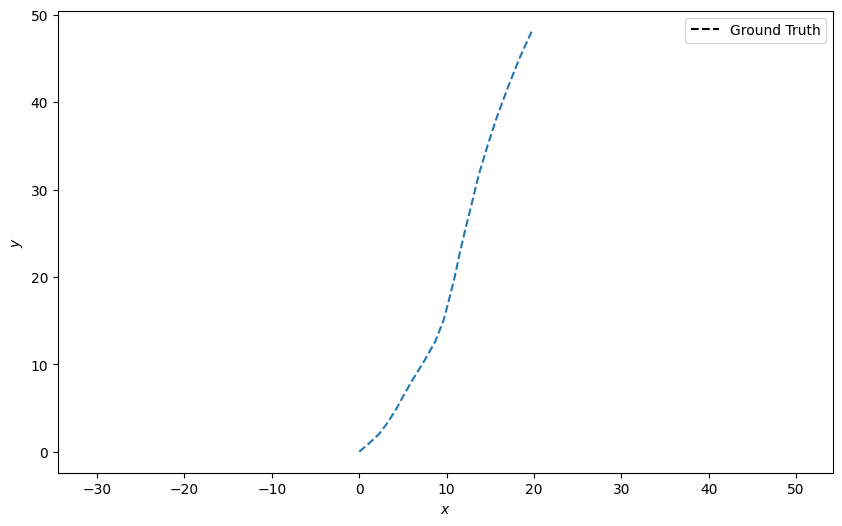

In [5]:
from stonesoup.plotter import Plotter
plotter = Plotter()
plotter.plot_ground_truths(truth, [0, 2])

### A bearing-range sensor

We're going to simulate a 2d bearing-range sensor. An example of this is available in Stone Soup
via the :class:`~.CartesianToBearingRange` class. As the name suggests, this takes the Cartesian
state input and returns a relative bearing and range to target. Specifically,

$$
\begin{align}\begin{bmatrix}
      \theta\\
      r\\
      \end{bmatrix}
      =
      \begin{bmatrix}
      \arctan\left(\frac{y-y_p}{x-x_p}\right)\\
      \sqrt{(x-x_p)^2 + (y-y_p)^2}
      \end{bmatrix}\end{align}
$$

where $x_p,y_p$ is the 2d Cartesian position of the sensor and $x,y$ that of the
target. Note also that the arctan function has to resolve the quadrant ambiguity and so is
implemented as the :class:`~.numpy.arctan2`$(y,x)$ function in Python.



In [6]:
from stonesoup.models.measurement.nonlinear import CartesianToBearingRange
sensor_x = 50  # Placing the sensor off-centre
sensor_y = 0

measurement_model = CartesianToBearingRange(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.diag([np.radians(0.2), 1]),  # Covariance matrix. 0.2 degree variance in
    # bearing and 1 metre in range
    translation_offset=np.array([[sensor_x], [sensor_y]])  # Offset measurements to location of
    # sensor in cartesian.
)

We create a set of detections using this sensor model.



In [7]:
from stonesoup.types.detection import Detection

measurements = []
for state in truth:
    measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection(measurement, timestamp=state.timestamp,
                                  measurement_model=measurement_model))

Plot the measurements. Where the model is nonlinear the plotting function uses the inverse
function to get coordinates.



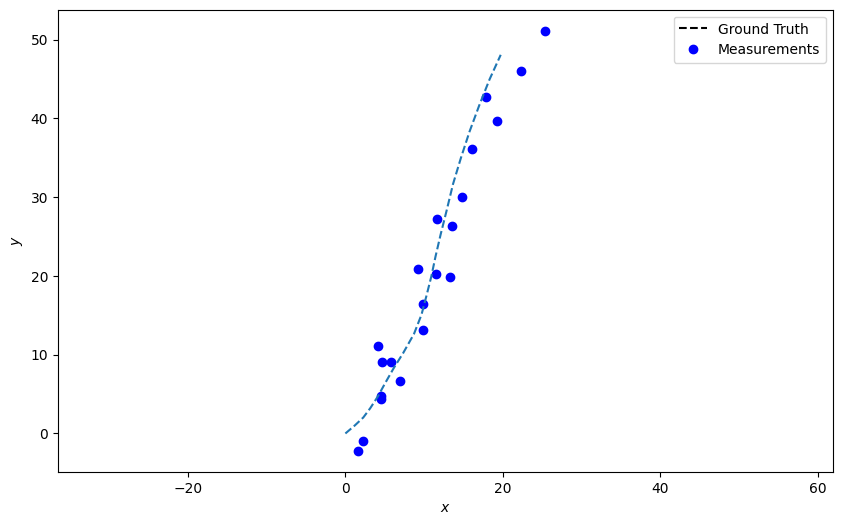

In [8]:
plotter.plot_measurements(measurements, [0, 2])
plotter.fig

### Set up the extended Kalman filter elements

Analogously to the Kalman filter, we now create the predictor and updater. As is our custom
the predictor takes a transition model and the updater a measurement model. Note that if either
of these models are linear then the extended predictor/updater defaults to its Kalman equivalent.
In fact the extended Kalman filter classes inherit nearly all of their functionality from the
Kalman classes. The only difference being that instead of returning a matrix, in the extended
version the :meth:`~.MeasurementModel.matrix()` function returns the Jacobian.



In [9]:
from stonesoup.predictor.kalman import ExtendedKalmanPredictor
predictor = ExtendedKalmanPredictor(transition_model)

from stonesoup.updater.kalman import ExtendedKalmanUpdater
updater = ExtendedKalmanUpdater(measurement_model)

### Run the extended Kalman filter
First, we'll create a prior state.



In [10]:
from stonesoup.types.state import GaussianState
prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

Next iterate over hypotheses and place in a track.



In [11]:
from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track

track = Track()
for measurement in measurements:
    prediction = predictor.predict(prior, timestamp=measurement.timestamp)
    hypothesis = SingleHypothesis(prediction, measurement)  # Group a prediction and measurement
    post = updater.update(hypothesis)
    track.append(post)
    prior = track[-1]

Plot the resulting track complete with error ellipses at each estimate.



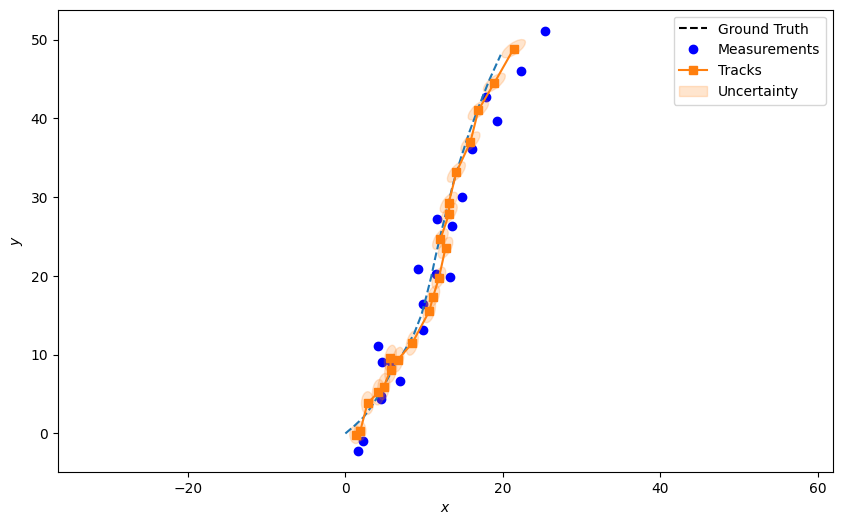

In [12]:
plotter.plot_tracks(track, [0, 2], uncertainty=True)
plotter.fig

## Key points
1. Non-linear models can be incorporated into the tracking scheme through the use of the
   appropriate combination of :class:`~.Predictor`/:class:`~.TransitionModel` or
   :class:`~.Updater`/:class:`~.MeasurementModel`
2. Because Stone Soup uses inheritance, the amount of engineering required to achieve this is
   minimal and the interface is the same. A user can apply the EKF components in exactly the same
   way as the KF.



The first order approximations used by the EKF provide a simple way to handle non-linear tracking
problems. However, in highly non-linear systems these simplifications can lead to large errors in
both the posterior state mean and covariance. In instances where we have noisy transition, or
perhaps unreliable measurement, this could lead to a sub-optimal performance or even divergence
of the filter. In the next tutorial, we see how the **unscented Kalman filter** can begin to
addresses these issues.



## References
.. [#] Anderson & Moore 2012, Optimal filtering,
       (http://users.cecs.anu.edu.au/~john/papers/BOOK/B02.PDF)

